In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import IPython.display as ipd
import pyximport
pyximport.install()
%load_ext Cython
import sigkernel as ksig
from utils.data import *
from model.generators import *

Text(0, 0.5, 'Output')

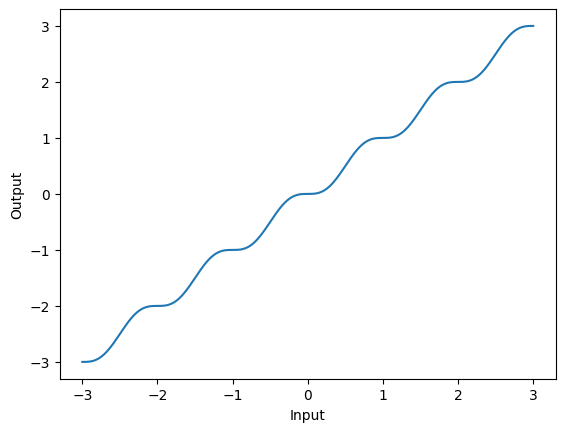

In [2]:
x = np.linspace(-3, 3, 601)
m = 2
y = x*2/m - np.sin(m*np.pi*x)/(m*np.pi)
plt.plot(x, y)
plt.xlabel('Input')
plt.ylabel('Output')

# Setup

In [3]:
hist_len = 8
sample_len = 30 #NOTE it includes the hist_len and if sample_len is greater than min_len of pre-processed dataset, the indices for song title will not match
noise_dim = 4
seq_dim = 3 # (gap, duration, pitch)
scale = 1.
dpitch_range = 24
stride = 800
folder = 'theorytab'

sigma = 1.0
kernel_type = 'truncated'
dyadic_order = 3
n_levels = 5
order = 1
lags = [1,2,3,4]

batch_size = 64
activation = 'Tanh'
hidden_size = 64
n_layers = 1

epochs = 100
patience = 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# with open(f'./data/dataframes/{folder}/melodies_beats_min_5_unique_max_range_24.pkl', 'rb') as f:
with open(f'./data/dataframes/{folder}/melodies_beats_min_5_unique_max_range_24_spec_cluster_12.pkl', 'rb') as f:
# with open(f'./data/dataframes/{folder}/all_melodies_within_key_beats_aligned_min_5_unique_max_range_21.pkl', 'rb') as f:
    songs = pickle.load(f)
len(songs)

7267

In [5]:
songs[0][1:]

('imai-asami', 'corpse-party---shangri-la', 'chorus_symbol_key.mid', 10)

In [6]:
cluster_labels = [item[-1] for item in songs]
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
unique_labels.shape, counts

((12,),
 array([ 904,  789,  455,  756,  544, 1173,  689,    4,  684,  407,  776,
          86]))

In [7]:
# separate the dataframes by cluster
df_clusters = []
for i in range(unique_labels.shape[0]):
    df_clusters.append([item for item in songs if item[-1] == i])
    print(i, len(df_clusters[-1]))

0 904
1 789
2 455
3 756
4 544
5 1173
6 689
7 4
8 684
9 407
10 776
11 86


In [8]:
lens = [len(item[0]) for item in songs]
print('Max length:', max(lens))
stride = max(lens) + 1 # ensures no sampling from middle of song

Max length: 394


In [9]:
# gap_dur_dpitch_dfs = gap_duration_deltapitch_transform([item[0] for item in songs])
# clusters = [item[4] for item in songs]
# dataset = GapDurationDeltaPitchDataset(gap_dur_dpitch_dfs, sample_len=sample_len, scale=scale, stride=stride, clusters=clusters)

cluster_idx = 5
gap_dur_dpitch_dfs = gap_duration_deltapitch_transform([item[0] for item in df_clusters[cluster_idx]])

# gap_dur_dpitch_dfs = gap_duration_deltapitch_transform([item[0] for item in songs])

dataset = GapDurationDeltaPitchDataset(gap_dur_dpitch_dfs, sample_len=sample_len, scale=scale, stride=stride)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
len(dataset), len(dataloader)

(1173, 18)

In [10]:
for i in range(len(dataset)):
    test1 = df_clusters[cluster_idx][i][0][:sample_len].values[:,:3].astype(np.float32)
    if test1.shape[0] < sample_len:
        print(f'Skipping {i} with shape {test1.shape}')
        continue
    test1[:,:2] -= df_clusters[cluster_idx][i][0].iloc[0,0]
    start_pitch = df_clusters[cluster_idx][i][0].iloc[0,2]
    test2 = batch_gap_duration_pitch_to_df(dataset[i][0].unsqueeze(0), start_pitch=start_pitch)[0].values[:,:3].astype(np.float32)
    if not np.allclose(test1, test2):
        print(f'Error in {i}')
        break

In [11]:
if kernel_type == 'truncated':
    static_kernel = ksig.static.kernels.RationalQuadraticKernel(sigma=sigma)
    # static_kernel = ksig.static.kernels.LinearKernel()
    kernel = ksig.kernels.SignatureKernel(n_levels=n_levels, order=order, normalization=0, static_kernel=static_kernel, device_ids=None)
elif kernel_type == 'pde':
    static_kernel = ksig.sigkernelpde.RationalQuadraticKernel(sigma=sigma, alpha=1.0)
    kernel = ksig.sigkernelpde.SigKernelPDE(static_kernel, dyadic_order)

In [12]:
# generator = LSTMgate(noise_dim, seq_dim, sample_len, hidden_size, n_layers, activation)
# generator = LSTMinc(noise_dim, seq_dim, sample_len, dpitch_range, scale, hidden_size, n_layers, activation)
generator = LSTMinc_v2(noise_dim, seq_dim, sample_len, dpitch_range, scale, hidden_size, n_layers, activation)
generator = generator.cuda()
optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, verbose=True)

In [13]:
# for item in dataloader:
#     X, _ = item
#     X_rect = batch_rectilinear_with_gap_transform(X[:, :, :])
#     X_rect = batch_lead_lag_transform(X_rect[:,:,1:], X_rect[:,:,:1], lags)
#     X_rect2 = batch_rectilinear_with_gap_transform(X[:, hist_len:, :])
#     X_rect2 = batch_lead_lag_transform(X_rect2[:,hist_len:,1:], X_rect2[:,hist_len:,:1], lags)
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     ax[0].plot(X_rect[0,:,0], X_rect[0,:,1:3])
#     ax[1].plot(X_rect2[0,:,0], X_rect2[0,:,1:3])
#     break

# Training

In [14]:
epoch_losses = []
lrs = []
for epoch in range(epochs):
    losses = []
    # noise = torch.randint(12, (batch_size, sample_len-1, noise_dim)).float().to(device)
    for batch_num, items in enumerate(tqdm(dataloader)):
        # X, title, cluster = items
        # cluster = cluster.to(device).unsqueeze(-1)
        X, title = items

        X = X.to(device)
        X_rect = batch_rectilinear_with_gap_transform(X[:, hist_len:, :])
        X_rect = batch_lead_lag_transform(X_rect[:,hist_len:,1:], X_rect[:,hist_len:,:1], lags)
        # X_rect = batch_rectilinear_with_gap_transform(X)
        # X_rect = batch_lead_lag_transform(X_rect[:,:,1:], X_rect[:,:,:1], lags)

        # For LSTMgate
        noise = torch.randn(X.shape[0], X.shape[1]-1, noise_dim).to(device)
        # Y = generator(noise, cluster, X[:, :hist_len, :], X[:, hist_len:, :2])

        # For LSTMinc
        # noise = torch.randn(X.shape[0], X.shape[1]-1, noise_dim).to(device)
        Y = generator(noise, X[:, :hist_len, :], X[:, hist_len:, :2])

        Y_rect = batch_rectilinear_with_gap_transform(Y[:, hist_len:, :])
        Y_rect = batch_lead_lag_transform(Y_rect[:,hist_len:,1:], Y_rect[:,hist_len:,:1], lags)
        # Y_rect = batch_rectilinear_with_gap_transform(Y)
        # Y_rect = batch_lead_lag_transform(Y_rect[:,:,1:], Y_rect[:,:,:1], lags)
        # print(output.shape, X.shape, X[:, :hist_len, :].shape)

        # compute loss
        optimizer.zero_grad()
        loss = ksig.tests.mmd_loss_no_compile(X_rect, Y_rect, kernel)
        losses.append(loss.item())

        # backpropagate and update weights
        loss.backward()
        optimizer.step()

    # log epoch loss and plot generated samples
    epoch_loss = np.average(losses) # average batch mmd for epoch
    epoch_losses.append(epoch_loss)
    scheduler.step(epoch_loss)
    # get lr of optimizer
    lrs.append(optimizer.param_groups[0]['lr'])
    print(f'Epoch {epoch+1}, loss: {epoch_loss}')
    if epoch_loss < 0.:
        sigma = sigma * 0.8
        static_kernel = ksig.static.kernels.RationalQuadraticKernel(sigma=sigma)
        kernel = ksig.kernels.SignatureKernel(n_levels=n_levels, order=order, normalization=0, static_kernel=static_kernel, device_ids=None)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, verbose=True)
        print(f'New sigma: {sigma}')

100%|██████████| 14/14 [00:02<00:00,  4.91it/s]


Epoch 1, loss: 55.485974652426584


100%|██████████| 14/14 [00:02<00:00,  5.63it/s]


Epoch 2, loss: 3.7645803349358693


100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Epoch 3, loss: 3.599616527557373


100%|██████████| 14/14 [00:02<00:00,  5.81it/s]


Epoch 4, loss: 3.7599845273154124


100%|██████████| 14/14 [00:02<00:00,  5.66it/s]


Epoch 5, loss: 3.4489082949502126


100%|██████████| 14/14 [00:02<00:00,  5.65it/s]


Epoch 6, loss: 3.363805191857474


100%|██████████| 14/14 [00:02<00:00,  5.60it/s]


Epoch 7, loss: 3.73090546471732


100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


Epoch 8, loss: 3.3066491740090505


100%|██████████| 14/14 [00:02<00:00,  5.78it/s]


Epoch 9, loss: 2.9895457540239607


100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


Epoch 10, loss: 2.9484172889164517


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch 11, loss: 2.8259799821036204


100%|██████████| 14/14 [00:02<00:00,  5.69it/s]


Epoch 12, loss: 2.7455381665910994


100%|██████████| 14/14 [00:02<00:00,  5.74it/s]


Epoch 13, loss: 2.4300427777426585


100%|██████████| 14/14 [00:02<00:00,  5.67it/s]


Epoch 14, loss: 2.4892356395721436


100%|██████████| 14/14 [00:02<00:00,  5.71it/s]


Epoch 15, loss: 2.310133831841605


100%|██████████| 14/14 [00:02<00:00,  5.74it/s]


Epoch 16, loss: 2.518997941698347


100%|██████████| 14/14 [00:02<00:00,  5.67it/s]


Epoch 17, loss: 2.3312947068895613


100%|██████████| 14/14 [00:02<00:00,  5.76it/s]


Epoch 18, loss: 2.2302177292960033


100%|██████████| 14/14 [00:02<00:00,  5.74it/s]


Epoch 19, loss: 2.124282121658325


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch 20, loss: 2.0352319989885603


100%|██████████| 14/14 [00:02<00:00,  5.74it/s]


Epoch 21, loss: 2.194703851427351


100%|██████████| 14/14 [00:02<00:00,  5.80it/s]


Epoch 22, loss: 2.2453043460845947


100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


Epoch 23, loss: 2.1825525420052663


100%|██████████| 14/14 [00:02<00:00,  5.55it/s]


Epoch 24, loss: 1.9426528385707311


100%|██████████| 14/14 [00:02<00:00,  5.60it/s]


Epoch 25, loss: 1.9945883069719588


100%|██████████| 14/14 [00:02<00:00,  5.62it/s]


Epoch 26, loss: 2.0622571536472867


100%|██████████| 14/14 [00:02<00:00,  5.90it/s]


Epoch 27, loss: 2.082817316055298


100%|██████████| 14/14 [00:02<00:00,  5.91it/s]


Epoch 28, loss: 1.899697950908116


100%|██████████| 14/14 [00:02<00:00,  5.94it/s]


Epoch 29, loss: 1.9422854355403356


100%|██████████| 14/14 [00:02<00:00,  5.95it/s]


Epoch 30, loss: 1.9508251462663924


100%|██████████| 14/14 [00:02<00:00,  5.94it/s]


Epoch 31, loss: 1.7997897693089075


100%|██████████| 14/14 [00:02<00:00,  5.93it/s]


Epoch 32, loss: 1.8015990257263184


100%|██████████| 14/14 [00:02<00:00,  5.92it/s]


Epoch 33, loss: 1.92653911454337


100%|██████████| 14/14 [00:02<00:00,  5.92it/s]


Epoch 34, loss: 1.8732941831861223


100%|██████████| 14/14 [00:02<00:00,  5.86it/s]


Epoch 35, loss: 1.8422677176339286


100%|██████████| 14/14 [00:02<00:00,  5.83it/s]


Epoch 36, loss: 1.7399757249014718


100%|██████████| 14/14 [00:02<00:00,  5.90it/s]


Epoch 37, loss: 1.673128264290946


100%|██████████| 14/14 [00:02<00:00,  5.91it/s]


Epoch 38, loss: 1.8270607335226876


100%|██████████| 14/14 [00:02<00:00,  5.92it/s]


Epoch 39, loss: 1.6215605395180839


100%|██████████| 14/14 [00:02<00:00,  5.91it/s]


Epoch 40, loss: 1.6765851633889335


100%|██████████| 14/14 [00:02<00:00,  5.89it/s]


Epoch 41, loss: 1.497770036969866


100%|██████████| 14/14 [00:02<00:00,  5.85it/s]


Epoch 42, loss: 1.8612080301557268


100%|██████████| 14/14 [00:02<00:00,  5.88it/s]


Epoch 43, loss: 1.6326449939182825


100%|██████████| 14/14 [00:02<00:00,  5.88it/s]


Epoch 44, loss: 1.59122862134661


100%|██████████| 14/14 [00:02<00:00,  5.93it/s]


Epoch 45, loss: 1.6354401792798723


100%|██████████| 14/14 [00:02<00:00,  5.91it/s]


Epoch 46, loss: 1.6114819731031145


100%|██████████| 14/14 [00:02<00:00,  5.92it/s]


Epoch 47, loss: 1.6082532405853271


100%|██████████| 14/14 [00:02<00:00,  5.92it/s]


Epoch 48, loss: 1.6777575697217668


100%|██████████| 14/14 [00:02<00:00,  5.90it/s]


Epoch 49, loss: 1.84031081199646


100%|██████████| 14/14 [00:02<00:00,  5.91it/s]


Epoch 50, loss: 1.638444525854928


100%|██████████| 14/14 [00:02<00:00,  5.90it/s]


Epoch 51, loss: 1.5991843768528529


100%|██████████| 14/14 [00:02<00:00,  5.89it/s]


Epoch 52, loss: 1.9823660850524902


100%|██████████| 14/14 [00:02<00:00,  5.93it/s]


Epoch 53, loss: 1.728896175112043


100%|██████████| 14/14 [00:02<00:00,  5.94it/s]


Epoch 54, loss: 1.7818055152893066


100%|██████████| 14/14 [00:02<00:00,  5.92it/s]


Epoch 55, loss: 1.5094412394932337


100%|██████████| 14/14 [00:02<00:00,  5.92it/s]


Epoch 56, loss: 1.7787201404571533


100%|██████████| 14/14 [00:02<00:00,  5.93it/s]


Epoch 57, loss: 1.4908631529126848


100%|██████████| 14/14 [00:02<00:00,  5.86it/s]


Epoch 58, loss: 1.7105587209974016


100%|██████████| 14/14 [00:02<00:00,  5.93it/s]


Epoch 59, loss: 1.8300365379878454


100%|██████████| 14/14 [00:02<00:00,  5.92it/s]


Epoch 60, loss: 1.8651470797402518


100%|██████████| 14/14 [00:02<00:00,  5.93it/s]


Epoch 61, loss: 1.4288862432752336


100%|██████████| 14/14 [00:02<00:00,  5.92it/s]


Epoch 62, loss: 1.6481471402304513


100%|██████████| 14/14 [00:02<00:00,  5.92it/s]


Epoch 63, loss: 1.413597754069737


100%|██████████| 14/14 [00:02<00:00,  5.88it/s]


Epoch 64, loss: 1.535367591040475


100%|██████████| 14/14 [00:02<00:00,  5.92it/s]


Epoch 65, loss: 1.6744952883039201


100%|██████████| 14/14 [00:02<00:00,  5.91it/s]


Epoch 66, loss: 1.5321710109710693


100%|██████████| 14/14 [00:02<00:00,  5.88it/s]


Epoch 67, loss: 1.3935603754861015


100%|██████████| 14/14 [00:02<00:00,  5.88it/s]


Epoch 68, loss: 1.6441891193389893


100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


Epoch 69, loss: 1.6436383043016707


100%|██████████| 14/14 [00:02<00:00,  5.81it/s]


Epoch 70, loss: 1.7211092880793981


100%|██████████| 14/14 [00:02<00:00,  5.84it/s]


Epoch 71, loss: 1.512402159827096


100%|██████████| 14/14 [00:02<00:00,  5.82it/s]


Epoch 72, loss: 1.4784728799547469


100%|██████████| 14/14 [00:02<00:00,  5.88it/s]


Epoch 73, loss: 1.522261483328683


100%|██████████| 14/14 [00:02<00:00,  5.80it/s]


Epoch 74, loss: 1.6015986715044295


100%|██████████| 14/14 [00:02<00:00,  5.87it/s]


Epoch 75, loss: 1.5189123153686523


100%|██████████| 14/14 [00:02<00:00,  5.87it/s]


Epoch 76, loss: 1.466592448098319


100%|██████████| 14/14 [00:02<00:00,  5.84it/s]


Epoch 77, loss: 1.6298607076917375


100%|██████████| 14/14 [00:02<00:00,  5.89it/s]


Epoch 78, loss: 1.5912267821175712


100%|██████████| 14/14 [00:02<00:00,  5.82it/s]


Epoch 79, loss: 1.6373450756072998


100%|██████████| 14/14 [00:02<00:00,  5.80it/s]


Epoch 80, loss: 1.7745346682412284


100%|██████████| 14/14 [00:02<00:00,  5.84it/s]


Epoch 81, loss: 1.483260222843715


100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


Epoch 82, loss: 1.6664490359170097


100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


Epoch 83, loss: 1.518230983189174


100%|██████████| 14/14 [00:02<00:00,  5.83it/s]


Epoch 84, loss: 1.514981644494193


100%|██████████| 14/14 [00:02<00:00,  5.86it/s]


Epoch 85, loss: 1.5795829977308


100%|██████████| 14/14 [00:02<00:00,  5.75it/s]


Epoch 86, loss: 1.8098265102931432


100%|██████████| 14/14 [00:02<00:00,  5.80it/s]


Epoch 87, loss: 1.801213196345738


100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


Epoch 00088: reducing learning rate of group 0 to 5.0000e-04.
Epoch 88, loss: 1.419599975858416


100%|██████████| 14/14 [00:02<00:00,  5.84it/s]


Epoch 89, loss: 1.7559784480503626


100%|██████████| 14/14 [00:02<00:00,  5.84it/s]


Epoch 90, loss: 1.6319023541041784


100%|██████████| 14/14 [00:02<00:00,  5.75it/s]


Epoch 91, loss: 1.52327333177839


100%|██████████| 14/14 [00:02<00:00,  5.86it/s]


Epoch 92, loss: 1.7621524333953857


100%|██████████| 14/14 [00:02<00:00,  5.81it/s]


Epoch 93, loss: 1.7242209230150496


100%|██████████| 14/14 [00:02<00:00,  5.81it/s]


Epoch 94, loss: 1.5657005650656564


100%|██████████| 14/14 [00:02<00:00,  5.81it/s]


Epoch 95, loss: 1.5683191163199288


100%|██████████| 14/14 [00:02<00:00,  5.84it/s]


Epoch 96, loss: 1.5149494920458113


100%|██████████| 14/14 [00:02<00:00,  5.77it/s]


Epoch 97, loss: 1.4621689319610596


100%|██████████| 14/14 [00:02<00:00,  5.85it/s]


Epoch 98, loss: 1.3875157151903426


100%|██████████| 14/14 [00:02<00:00,  5.80it/s]


Epoch 99, loss: 1.4265891824449812


100%|██████████| 14/14 [00:02<00:00,  5.82it/s]

Epoch 100, loss: 1.419412408556257


Text(0.5, 1.0, 'Learning Rate')

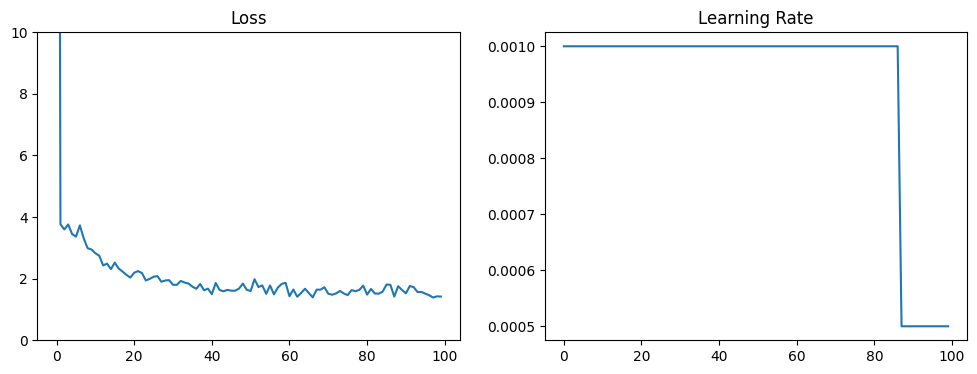

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(epoch_losses)
ax[0].set_title('Loss')
ax[0].set_ylim(0, 10)
ax[1].plot(lrs)
ax[1].set_title('Learning Rate')

In [16]:
# torch.save(generator.state_dict(), f'./data/weights/lstm_v7.pt')

# Evaluation

In [13]:
# for k, v in torch.load(f'./data/weights/lstm_v2.pt').items():
#     print(k, v.shape)
# generator.load_state_dict(torch.load(f'./data/weights/lstm_v6.pt'))

rnn.weight_ih_l0 torch.Size([1024, 8])
rnn.weight_hh_l0 torch.Size([1024, 256])
rnn.bias_ih_l0 torch.Size([1024])
rnn.bias_hh_l0 torch.Size([1024])
output_net.0.weight torch.Size([256, 256])
output_net.0.bias torch.Size([256])
output_net.2.weight torch.Size([1, 256])
output_net.2.bias torch.Size([1])


<All keys matched successfully>

### Sample and play MIDI

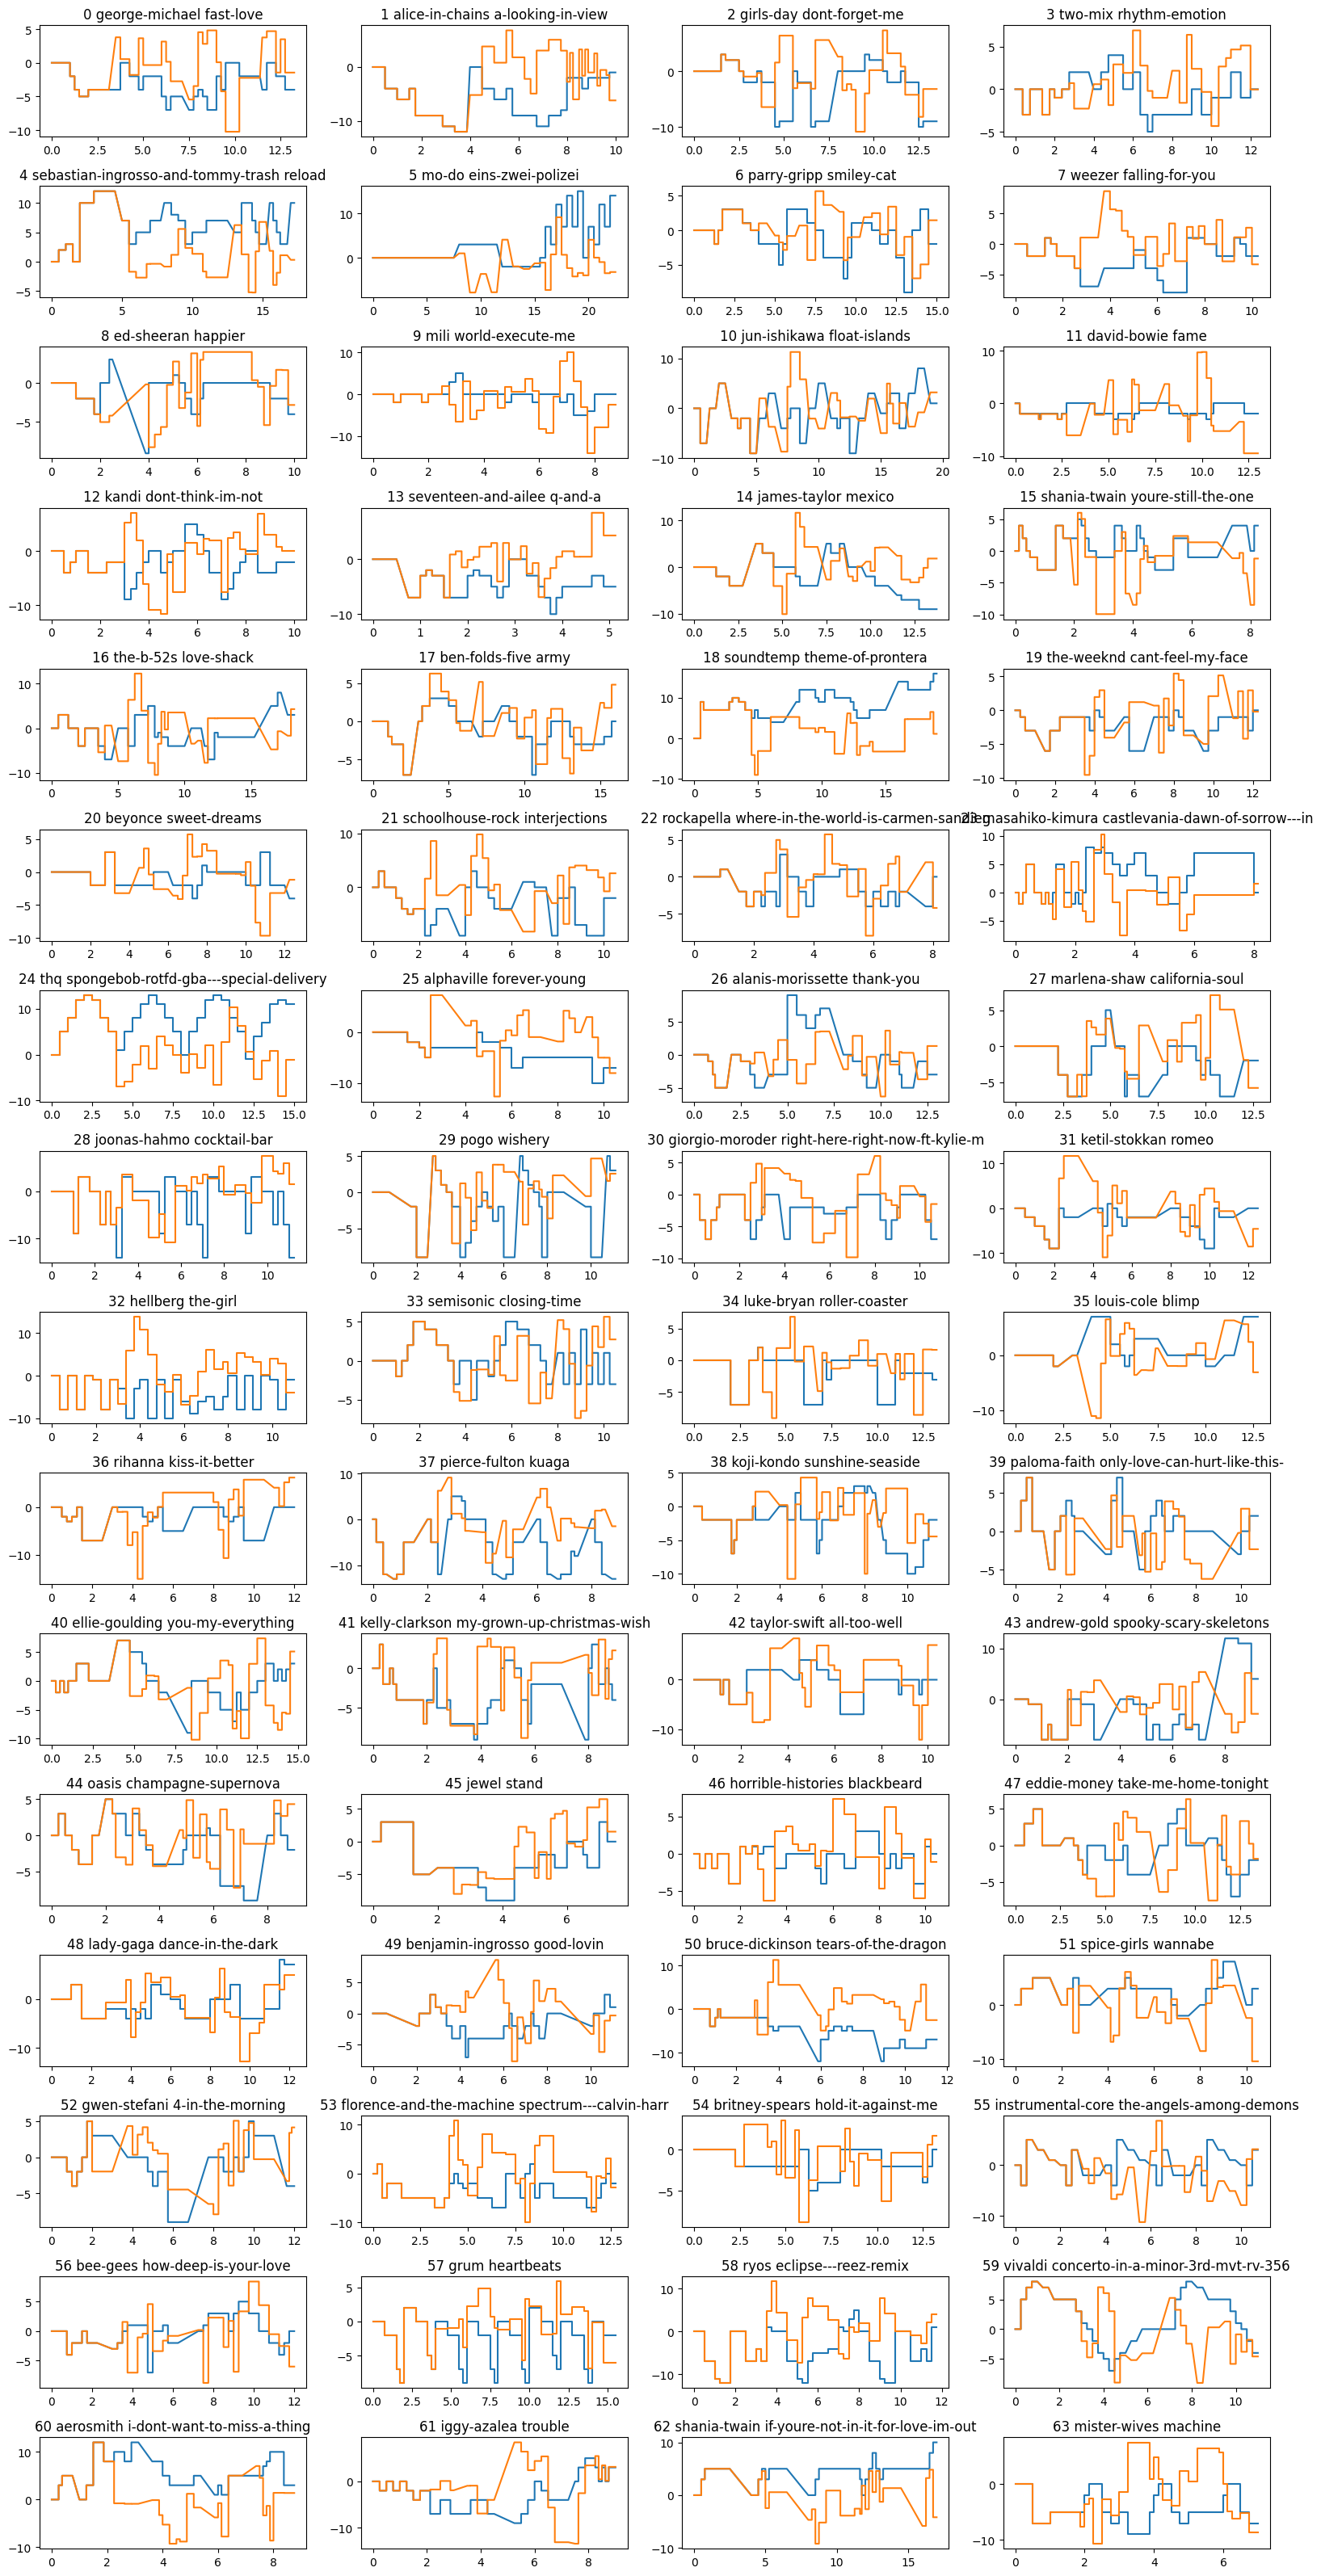

In [21]:
for items in dataloader:
    X, title = items
    X = X.to(device)
    noise = torch.randn(X.shape[0], X.shape[1]-1, noise_dim).to(device)
    Y = generator(noise, X[:, :hist_len, :], X[:, hist_len:, :2])
    break
X_titles = []
for arg in title:
    X_titles.append((df_clusters[cluster_idx][arg.item()][1], df_clusters[cluster_idx][arg.item()][2], df_clusters[cluster_idx][arg.item()][3]))
start_pitch = 74
X[:,:,-1] /= scale
Y[:,:,-1] /= scale
X_dfs = batch_gap_duration_pitch_to_df(X, start_pitch=start_pitch)
Y_dfs = batch_gap_duration_pitch_to_df(Y, start_pitch=start_pitch)
np_X_rect = batch_rectilinear_with_gap_transform(X).cpu().numpy()
np_Y_rect = batch_rectilinear_with_gap_transform(Y).detach().cpu().numpy()
fig, ax = plt.subplots(batch_size//4, 4, figsize=(16, batch_size//2))
for i in range(batch_size//4):
    for j in range(4):
        if batch_size//4 == 1:
            ax[j].plot(np_X_rect[j,:,0], np_X_rect[j,:,1]/scale)
            ax[j].plot(np_Y_rect[j,:,0], np_Y_rect[j,:,1]/scale)
            ax[j].set_title((f'{j} {X_titles[j][0]} {X_titles[j][1]}')[:50])
        else:
            ax[i, j].plot(np_X_rect[i*4+j,:,0], np_X_rect[i*4+j,:,1]/scale)
            ax[i, j].plot(np_Y_rect[i*4+j,:,0], np_Y_rect[i*4+j,:,1]/scale)
            ax[i, j].set_title((f'{i*4+j} {X_titles[i*4+j][0]} {X_titles[i*4+j][1]}')[:50])
plt.tight_layout()

In [22]:
sample_idx = 0
print(X_titles[sample_idx])
input_midi = df_to_midi(X_dfs[sample_idx])
output_midi = df_to_midi(Y_dfs[sample_idx])

('george-michael', 'fast-love', 'chorus_symbol_key.mid')


In [23]:
# input_midi = df_to_midi(pd.read_csv('data/dataframes/demo/input_abba_thank-you-for-the-music_bridge_symbol_key.mid.csv'))
# output_midi = df_to_midi(pd.read_csv('data/dataframes/demo/output_abba_thank-you-for-the-music_bridge_symbol_key.mid.csv'))

In [24]:
print(df_clusters[cluster_idx][title[sample_idx].item()][1:])
arg = title[sample_idx]
print((df_clusters[cluster_idx][arg.item()][1], df_clusters[cluster_idx][arg.item()][2], df_clusters[cluster_idx][arg.item()][3]))
midi = df_to_midi(df_clusters[cluster_idx][title[sample_idx].item()][0])
ipd.Audio(midi.fluidsynth(), rate=44100)

('george-michael', 'fast-love', 'chorus_symbol_key.mid', 5)
('george-michael', 'fast-love', 'chorus_symbol_key.mid')


In [25]:
fs=44100
input_audio_data = input_midi.fluidsynth(fs=fs, sf2_path='./data/soundfonts/Steinway_Grand_Piano_1.2.sf2')
ipd.Audio(input_audio_data, rate=fs)

In [26]:
fs=44100
output_audio_data = output_midi.fluidsynth(fs=fs, sf2_path='./data/soundfonts/Steinway_Grand_Piano_1.2.sf2')
ipd.Audio(output_audio_data, rate=fs)

### Save output in MIDI dataframe and WAV

In [20]:
# from scipy.io.wavfile import write
# rate = 44100
# scaled = np.int16(input_audio_data / np.max(np.abs(input_audio_data)) * 32767)
# write(f'./data/dataframes/demo/input_{X_titles[sample_idx][0]}_{X_titles[sample_idx][1]}_{X_titles[sample_idx][2]}.wav', rate, scaled)
# scaled = np.int16(output_audio_data / np.max(np.abs(output_audio_data)) * 32767)
# write(f'./data/dataframes/demo/output_{X_titles[sample_idx][0]}_{X_titles[sample_idx][1]}_{X_titles[sample_idx][2]}.wav', rate, scaled)

In [25]:
# pd.merge(X_dfs[sample_idx][['Start', 'End', 'Pitch']], Y_dfs[sample_idx][['Pitch']], left_index=True, right_index=True)

In [59]:
# X_dfs[sample_idx].to_csv(f'./data/dataframes/demo/input_{X_titles[sample_idx][0]}_{X_titles[sample_idx][1]}_{X_titles[sample_idx][2]}.csv', index=False)
# Y_dfs[sample_idx].to_csv(f'./data/dataframes/demo/output_{X_titles[sample_idx][0]}_{X_titles[sample_idx][1]}_{X_titles[sample_idx][2]}.csv', index=False)

### Evaluate note within key percentages

In [28]:
Xs = []
Ys = []
for item in dataloader:
    X, title = item
    Xs.append(X)
    X = X.to(device)
    X_rect = batch_rectilinear_with_gap_transform(X[:, hist_len:, :])

    noise = torch.randn(X.shape[0], X.shape[1]-1, noise_dim).to(device)
    Y = generator(noise, X[:, :hist_len, :], X[:, hist_len:, :2])
    Ys.append(Y.detach().cpu())
    Y_rect = batch_rectilinear_with_gap_transform(Y[:, hist_len:, :])

Xs = torch.cat(Xs, dim=0)
Ys = torch.cat(Ys, dim=0)
print(Xs.shape, Ys.shape)
all_X_dfs = batch_gap_duration_pitch_to_df(Xs, start_pitch=start_pitch)
all_Y_dfs = batch_gap_duration_pitch_to_df(Ys, start_pitch=start_pitch)

torch.Size([1152, 30, 3]) torch.Size([1152, 30, 3])


In [29]:
key_to_note = {0: 'C', 1: 'C#', 2: 'D', 3: 'D#', 4: 'E', 5: 'F', 6: 'F#', 7: 'G', 8: 'G#', 9: 'A', 10: 'A#', 11: 'B'}
key_notes = []
for i in range(12):
    key_notes.append(get_notes_from_major_scale(i))

In [30]:
# check percentage of notes in C major scale
X_key_percentages = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: []}
Y_key_percentages = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: []}
for df in all_X_dfs:
    for i in range(len(key_notes)):
        percentage = len([note for note in df['Pitch'].values if note in key_notes[i]]) / len(df['Pitch'].values)
        X_key_percentages[i].append(percentage)
for df in all_Y_dfs:
    for i in range(len(key_notes)):
        percentage = len([note for note in df['Pitch'].values if note in key_notes[i]]) / len(df['Pitch'].values)
        Y_key_percentages[i].append(percentage)

In [49]:
from pandas.io import clipboard

def mad(data, axis=0):
    return np.mean(np.abs(data - np.mean(data, axis)), axis)

key_df = pd.DataFrame(columns=['Key',
                               'Mean (reference)',
                            #    'Std (reference)',
                               'Mean (generated)',])
                            #    'Std (generated)'])
rows = []
for i in range(12):
    row = {'Key': key_to_note[i],
           'Mean (reference)': np.mean(X_key_percentages[i]),
        #    'Std (reference)': mad(X_key_percentages[i]),
           'Mean (generated)': np.mean(Y_key_percentages[i]),}
        #    'Std (generated)': mad(Y_key_percentages[i])}
    rows.append(row)
key_df = pd.concat([key_df, pd.DataFrame(rows)], ignore_index=True)
clipboard.copy(key_df.to_latex(index=False, float_format='%.2f'))
key_df.to_csv('./key.csv', index=False, float_format='%.2f')
key_df

/tmp/ipykernel_15963/2025825101.py:20: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  clipboard.copy(key_df.to_latex(index=False, float_format='%.2f'))


Key  Mean (reference)  Mean (generated)
0    C          0.792679          0.648466
1   C#          0.452778          0.541435
2    D          0.590885          0.593750
3   D#          0.788281          0.649855
4    E          0.259693          0.485156
5    F          0.872917          0.663600
6   F#          0.324277          0.500000
7    G          0.734462          0.630382
8   G#          0.525289          0.551100
9    A          0.502951          0.573929
10  A#          0.866522          0.664641
11   B          0.289265          0.497685

Key: D
Mean percentage of notes in key C: 0.7926793981481483
Mean percentage of notes in key C#: 0.4527777777777778
Mean percentage of notes in key D: 0.5908854166666666
Mean percentage of notes in key D#: 0.78828125
Mean percentage of notes in key E: 0.259693287037037
Mean percentage of notes in key F: 0.8729166666666667
Mean percentage of notes in key F#: 0.32427662037037036
Mean percentage of notes in key G: 0.7344618055555556
Mean percentage of notes in key G#: 0.5252893518518518
Mean percentage of notes in key A: 0.5029513888888889
Mean percentage of notes in key A#: 0.8665219907407408
Mean percentage of notes in key B: 0.2892650462962963


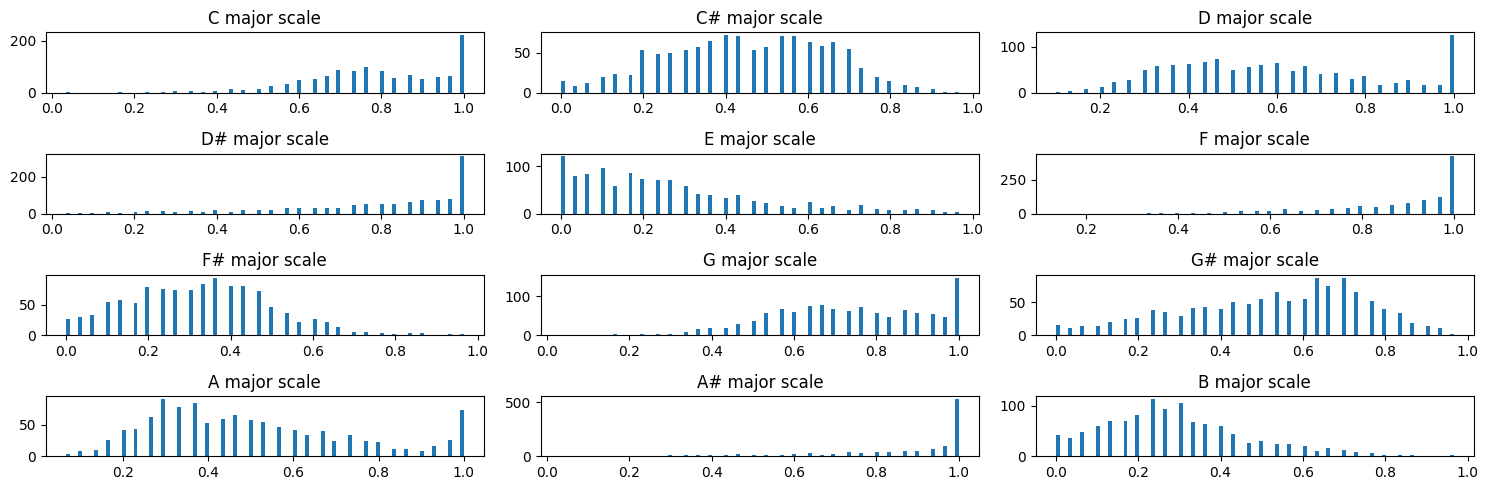

In [31]:
fig, ax = plt.subplots(4, 3, figsize=(15, 5))
print(f'Key: {key_to_note[start_pitch % 12]}')
for i in range(len(key_notes)):
    print(f'Mean percentage of notes in key {key_to_note[i]}: {np.mean(X_key_percentages[i])}')
    ax[i//3, i%3].hist(X_key_percentages[i], bins=100)
    ax[i//3, i%3].set_title(f'{key_to_note[i]} major scale')
plt.tight_layout()

Key: D
Mean percentage of notes in key C: 0.6484664351851852
Mean percentage of notes in key C#: 0.5414351851851852
Mean percentage of notes in key D: 0.59375
Mean percentage of notes in key D#: 0.6498553240740742
Mean percentage of notes in key E: 0.48515624999999996
Mean percentage of notes in key F: 0.6635995370370371
Mean percentage of notes in key F#: 0.5
Mean percentage of notes in key G: 0.6303819444444445
Mean percentage of notes in key G#: 0.5510995370370371
Mean percentage of notes in key A: 0.5739293981481481
Mean percentage of notes in key A#: 0.6646412037037037
Mean percentage of notes in key B: 0.4976851851851851


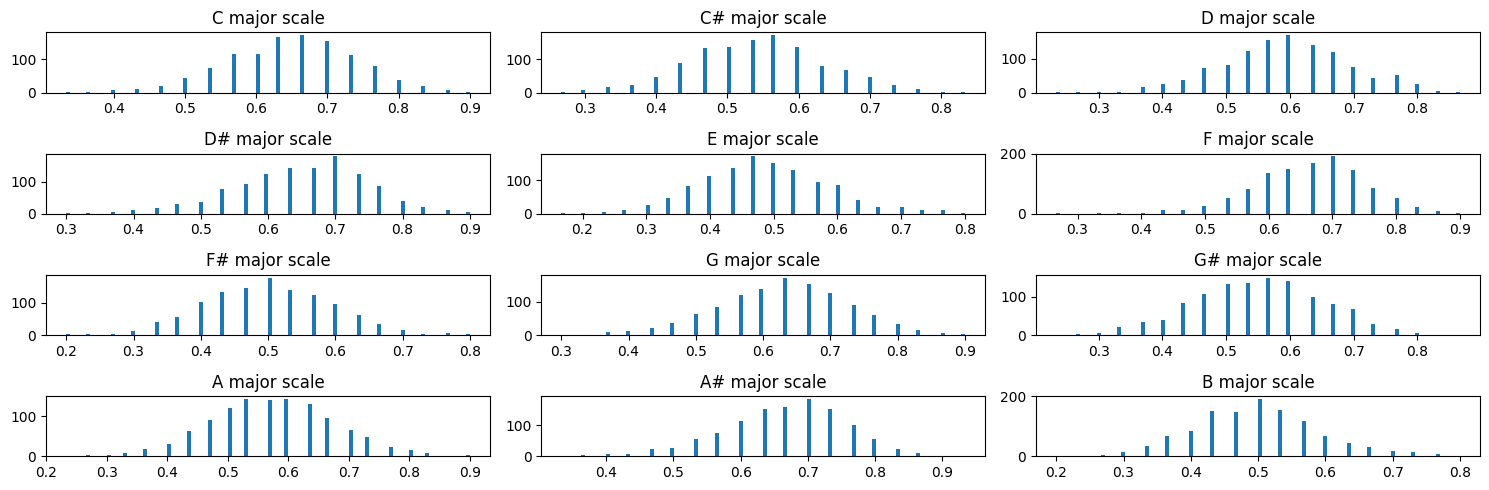

In [32]:
fig, ax = plt.subplots(4, 3, figsize=(15, 5))
print(f'Key: {key_to_note[start_pitch % 12]}')
for i in range(len(key_notes)):
    print(f'Mean percentage of notes in key {key_to_note[i]}: {np.mean(Y_key_percentages[i])}')
    ax[i//3, i%3].hist(Y_key_percentages[i], bins=100)
    ax[i//3, i%3].set_title(f'{key_to_note[i]} major scale')
plt.tight_layout()